# Data Pipeline - Preaperation

In [1]:
import pandas as pd # for dataframe
import joblib # for save model
import yaml
import os
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats 
import pylab
import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
params_dir = "config/times_params.yaml"

In [4]:
def load_params(param_dir):
    with open(param_dir, 'r') as file:
        params = yaml.safe_load(file)
        
    return params

In [5]:
params = load_params(params_dir)

# 1. Data Collection

In [6]:
# fungsi untuk membaca nama file, memuat file, dan menggabungkan dataset
def read_dataset(dataset_dir):
    """
    Function for read name file, load file, and
    merge datsheet
    """
    dataset = pd.DataFrame()

    for i in tqdm(os.listdir(dataset_dir)):
        dataset = pd.concat([pd.read_csv(dataset_dir + i), dataset])
    
    return dataset

In [7]:
# Read file
df =read_dataset(params["dataset_dir"])
df.head(2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany


In [8]:
# drop columns unused
df = df.drop(columns=['4046', '4225', '4770','Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year', 'region','Unnamed: 0'])

In [9]:
# rename column
df.rename(columns = {'Total Volume' : 'Total_sold'}, inplace = True)

In [10]:
# sanichek
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total_sold    18249 non-null  float64
dtypes: float64(2), object(1)
memory usage: 427.8+ KB


# 2. Data Validation

### Make new columns 

In [11]:
# return data (for see change from previous day to today)
df['ret_price'] = df['AveragePrice'].pct_change(1).mul(100)
df['ret_sold'] = df['Total_sold'].pct_change(1).mul(100)

## Handling Missing nulls

In [12]:
# check null values
df.isnull().sum()

Date            0
AveragePrice    0
Total_sold      0
ret_price       1
ret_sold        1
dtype: int64

In [13]:
# change dtypes
df.Date = pd.to_datetime(df.Date, dayfirst = True)
df.sort_values(by='Date', inplace = True)
df = df.reset_index(drop=True)

# use if data there are nulls values
#df=df.asfreq('b') 
df = df.fillna(method='bfill')

# Handling Duplicate Values

In [14]:
# check duplicate
df.duplicated().sum()

0

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   AveragePrice  18249 non-null  float64       
 2   Total_sold    18249 non-null  float64       
 3   ret_price     18249 non-null  float64       
 4   ret_sold      18249 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 713.0 KB


In [16]:
# range of data
def minmax(input_data, column_name):
    """
    Function for check range data
    """
    min_data = input_data[column_name].min()
    max_data = input_data[column_name].max()
    
    print(f'min range of values {min_data}, max range of values {max_data}')

In [17]:
# call function for check output
minmax(df, 'AveragePrice')
minmax(df, 'Total_sold')
minmax(df, 'ret_price')
minmax(df, 'ret_sold')

min range of values 0.44, max range of values 3.25
min range of values 84.56, max range of values 62505646.52
min range of values -63.1578947368421, max range of values 155.88235294117646
min range of values -99.88758518272398, max range of values 29059.025287990324


# 3. Data Defense

In [18]:
# check data types
def check_data(input_data, params):
    # check data types
    assert input_data.select_dtypes("float64").columns.to_list() == params["float_columns"], "an error occurs in float64 column(s)."
    
    #check range of data
    assert input_data.AveragePrice.between(params["range_price"][0], params["range_price"][1]).sum() == len(input_data), "an error occurs in avg_price range."
    assert input_data.Total_sold.between(params["range_sold"][0], params["range_sold"][1]).sum() == len(input_data), "an error occurs in avg_price range."
    assert input_data.ret_price.between(params["range_ret_price"][0], params["range_ret_price"][1]).sum() == len(input_data), "an error occurs in return_price range."
    assert input_data.ret_sold.between(params["range_ret_sold"][0], params["range_ret_sold"][1]).sum() == len(input_data), "an error occurs in return_sold range."

In [19]:
# if data not found error, the mean are suitable with we are design
check_data(df, params)

# Eksploratory Data Analysis

# Distribution data

<AxesSubplot:xlabel='AveragePrice', ylabel='Density'>

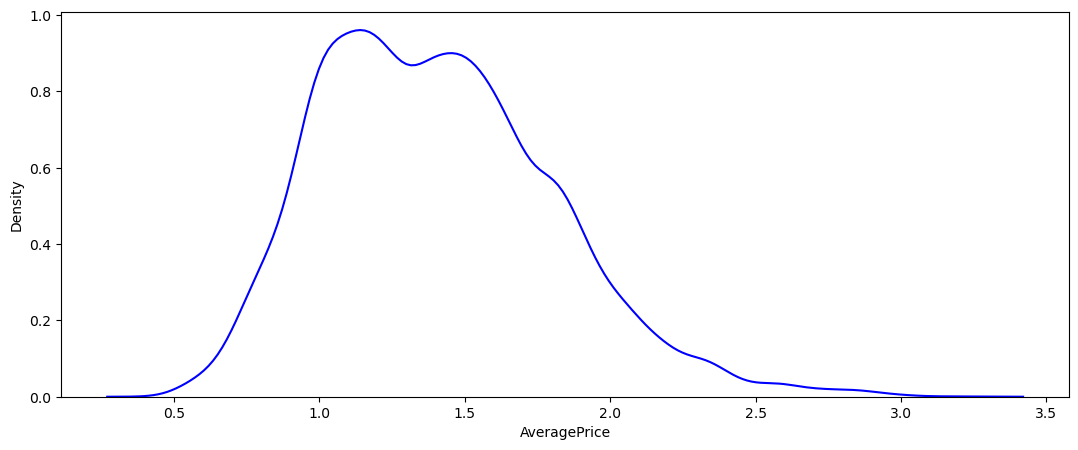

In [20]:
# dist of avgprice
plt.figure(figsize=(13, 5))
sns.kdeplot(data=df, x="AveragePrice",color="blue")

<AxesSubplot:xlabel='Total_sold', ylabel='Density'>

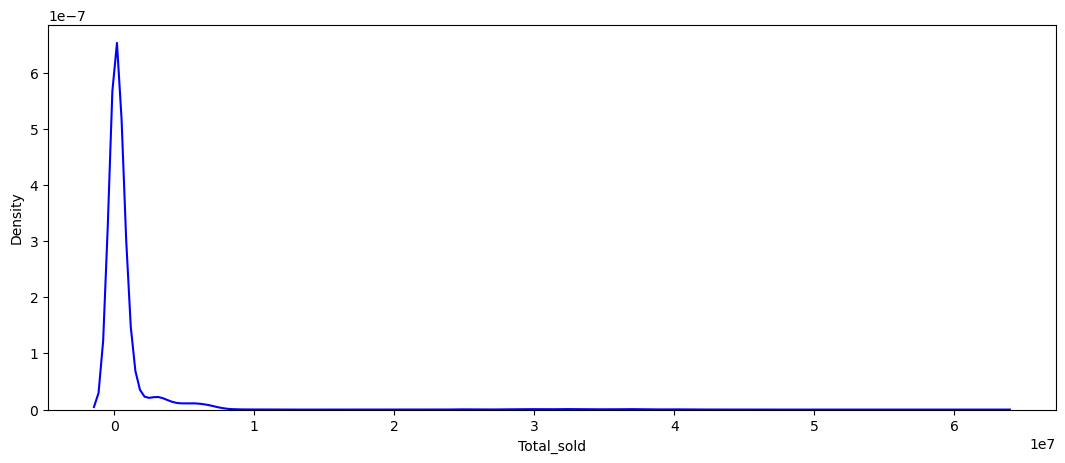

In [21]:
# dist of total sold
plt.figure(figsize=(13, 5))
sns.kdeplot(data=df, x="Total_sold",color="blue")

# Check Normal Distribution ( QQ Method)

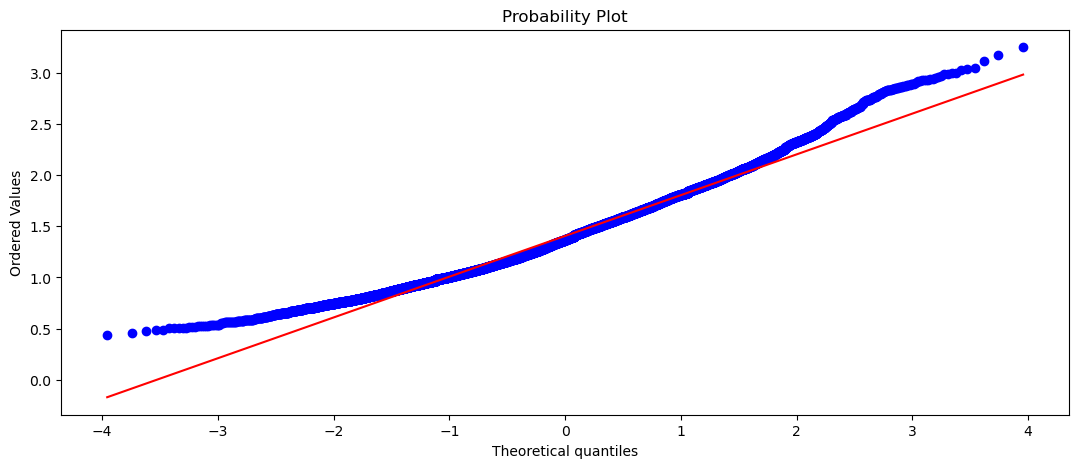

In [22]:
# Normal dist avg price
plt.figure(figsize=(13, 5))
scipy.stats.probplot(df.AveragePrice, plot = pylab)
pylab.show()

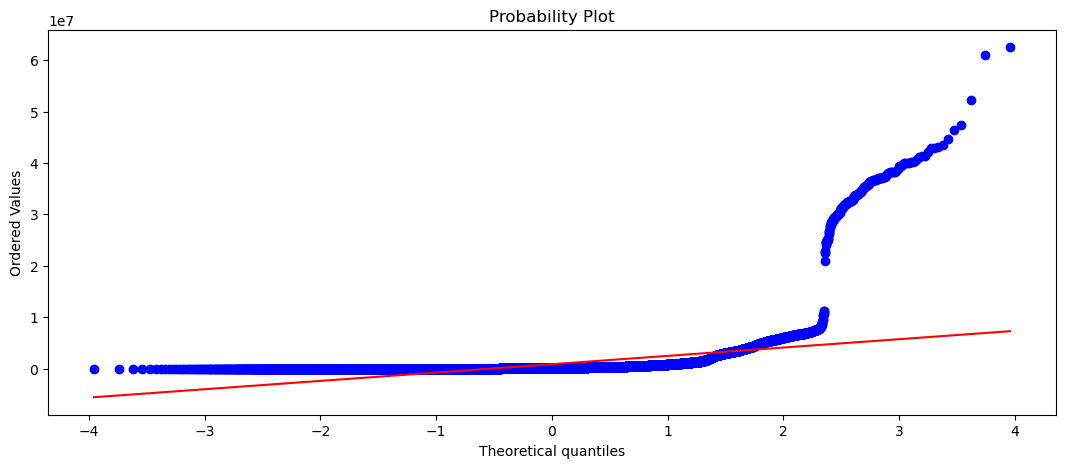

In [23]:
# Normal dist Total sold
plt.figure(figsize=(13, 5))
scipy.stats.probplot(df.Total_sold, plot = pylab)
pylab.show()

The result of the dist is not normal because data not follow red line, mean is not good for forcasting

# Plotting data

<AxesSubplot:xlabel='Date', ylabel='AveragePrice'>

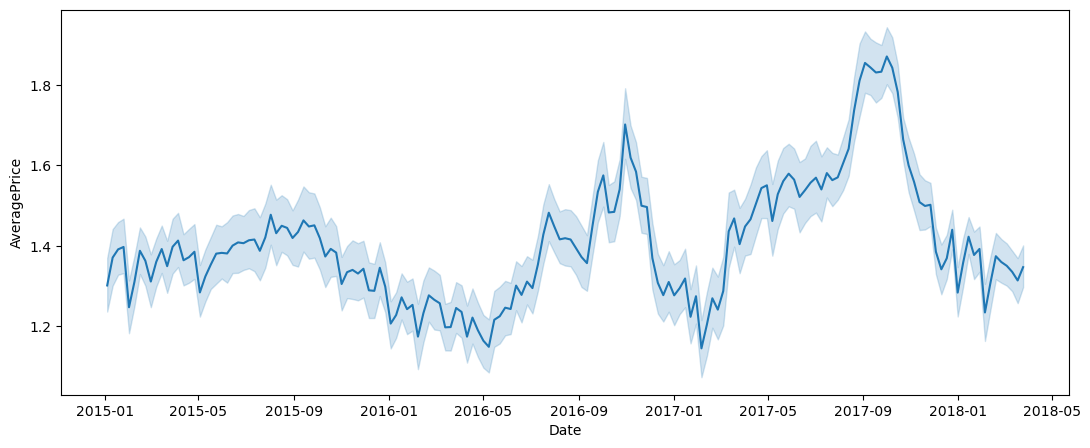

In [24]:
# plot avg price
plt.figure(figsize=(13, 5))
sns.lineplot(x = "Date", y = "AveragePrice", data = df)

<AxesSubplot:xlabel='Date', ylabel='Total_sold'>

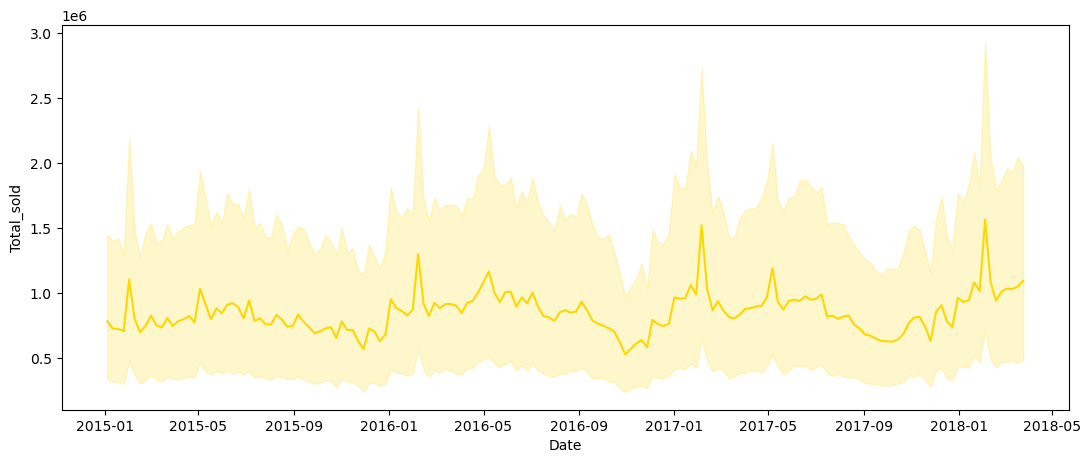

In [25]:
# plot total sold
plt.figure(figsize=(13, 5))
sns.lineplot(x = "Date", y = "Total_sold", data = df, color = "gold")

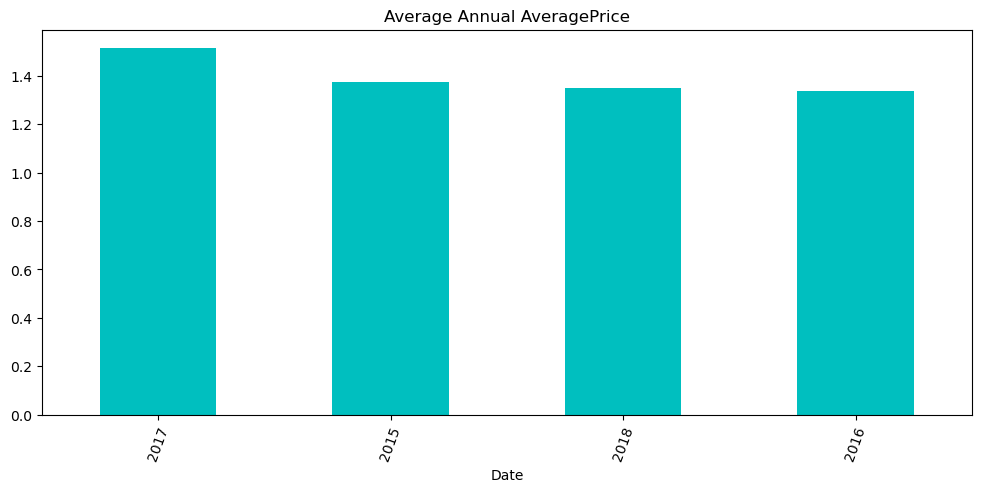

In [26]:
# plot annual of avgprice
yearly_avg = df.groupby(df['Date'].dt.year)['AveragePrice'].mean().sort_values(ascending=False)

plt.rcParams["figure.figsize"] = [12,5]
yearly_avg.plot.bar(rot=70, title="Average Annual AveragePrice", align='center', color = 'c')
plt.show(block=True)

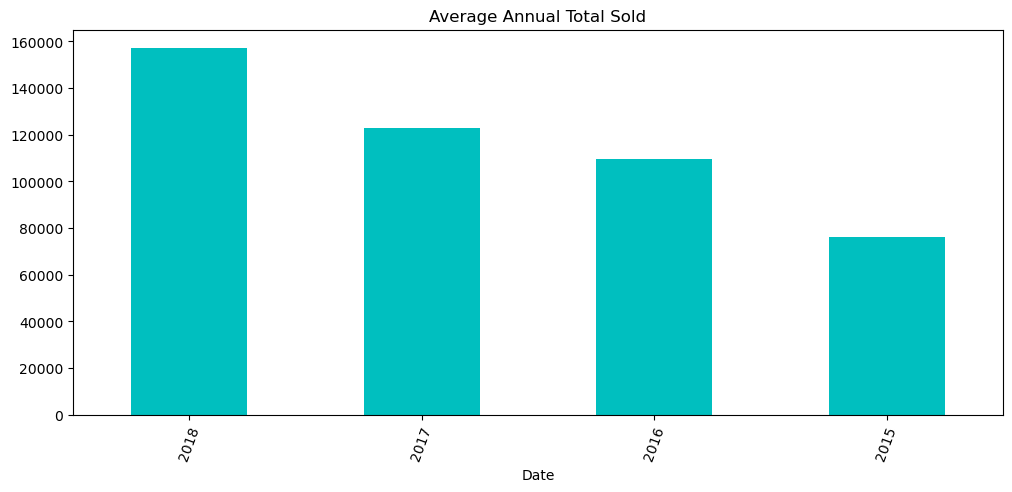

In [27]:
# plot annual of Total sold
yearly_sold = df.groupby(df['Date'].dt.year)['Total_sold'].median().sort_values(ascending=False)

plt.rcParams["figure.figsize"] = [12,5]
yearly_sold.plot.bar(rot=70, title="Average Annual Total Sold", align='center', color = 'c')
plt.show(block=True)

<AxesSubplot:xlabel='Date', ylabel='AveragePrice'>

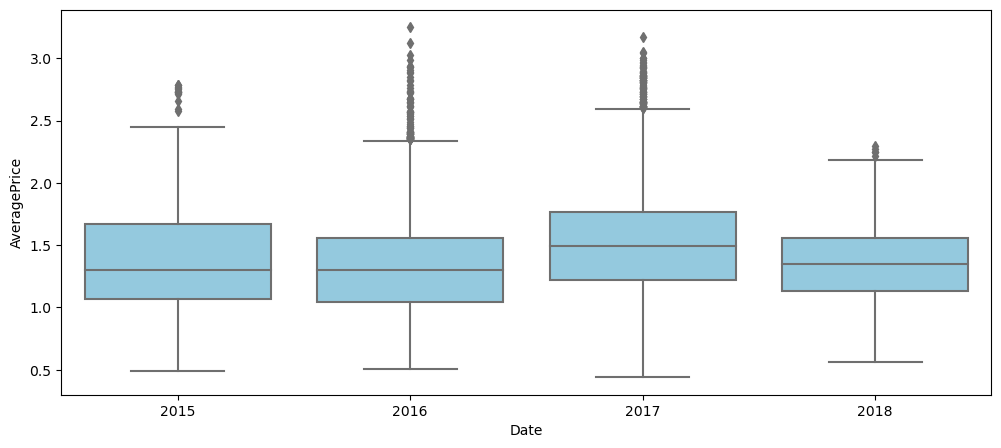

In [28]:
# check outliar avgprice annual
sns.boxplot(x=df['Date'].dt.year, y=df['AveragePrice'], color="skyblue")

<AxesSubplot:xlabel='Date', ylabel='Total_sold'>

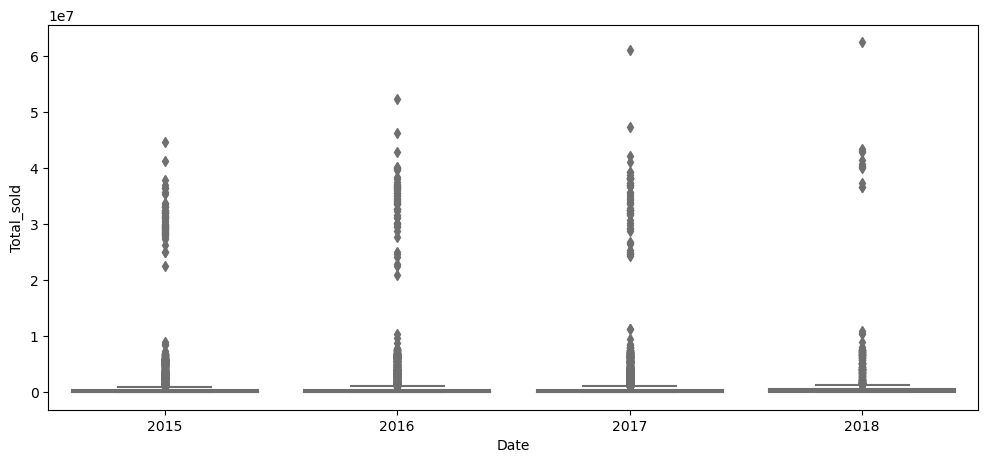

In [29]:
# check outliar total_sold annual
sns.boxplot(x=df['Date'].dt.year, y=df['Total_sold'], color="skyblue")

# Correlation Data

<AxesSubplot:>

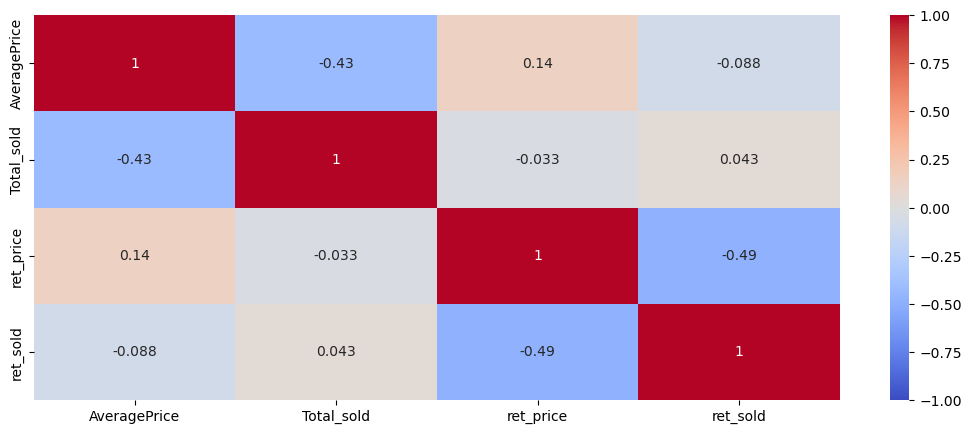

In [30]:
# cor multivariant Numeric vs numeric use Kernel (method)
corr = df.corr(method='kendall')

# plot corr with heatmap
plt.figure(figsize=(13, 5))
sns.heatmap(corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1)

# Analysis Statistic 

The Dicky Fuller test can be used to determine the stationarity of a time series. It provides a statistical value that can be combined with the simple eye test. A time series (TS) being stationary indicates we can use autoregressive and moving average models to predict future values based of past data. First, we will create functions that allow us to test a Time Series' stationairty and plot the TS to help visualise this.

In [31]:
df.set_index('Date', inplace = True)  #set the date column as the index column
df.index

DatetimeIndex(['2015-01-04', '2015-01-04', '2015-01-04', '2015-01-04',
               '2015-01-04', '2015-01-04', '2015-01-04', '2015-01-04',
               '2015-01-04', '2015-01-04',
               ...
               '2018-03-25', '2018-03-25', '2018-03-25', '2018-03-25',
               '2018-03-25', '2018-03-25', '2018-03-25', '2018-03-25',
               '2018-03-25', '2018-03-25'],
              dtype='datetime64[ns]', name='Date', length=18249, freq=None)

In [32]:
# make new data just one columns for test stationary
df_sold = df[['Total_sold']]
df_price = df[['AveragePrice']]
df_ret_price = df[['ret_price']]
df_ret_sold = df[['ret_sold']]

In [33]:
#define a function to plot the rolling mean and rolling standard deviation of the time series
def TestStationaryPlot(ts):
    """
    This function for know moving average
    in time series from time to time
    Step : 
    - include data and one columns
    - plot result rolling mean, std, and data original
    """
    rolling_mean = ts.rolling(window = 7, center = False).mean()
    rolling_std = ts.rolling(window = 7, center = False).std()
    
    rolling_mean.dropna(inplace = True)
    rolling_std.dropna(inplace = True)
    
    fig, ax = plt.subplots(figsize = (11, 5))
    plt.title('Rolling Mean & Standard Deviation', fontsize = 15)
    
    diff_factor = (rolling_mean.mean()/rolling_std.mean())
    
    if int(diff_factor) > 10:  # Plot 1 (STD is 1 factor smaller than the mean values)
        # using the twinx() for creating another
        # axes object for secondary y-Axis
        ax2 = ax.twinx()
        ax.plot(ts, color = 'blue',label = 'Original TS')
        ax.plot(rolling_mean, color = 'red', label = 'TS Rolling Mean')
        ax2.plot(rolling_std, color ='black', label = 'TS Rolling Std')
    
        # giving labels to the axises
        ax.set_xlabel('Year', fontsize = 15)
        ax.set_ylabel('Total CO2 count', fontsize = 15)
        ax.legend(loc=0, fontsize = 15)
        ax2.legend(loc=0,bbox_to_anchor=(0.26, 0.82), fontsize = 15)
    
        # secondary y-axis label
        ax2.set_ylabel('Total CO2 count (STD axis)', fontsize = 15)
        # defining display layout
        #plt.legend(loc=0, fontsize = 15)
        plt.tight_layout()
    
    else: # Plot 1 (STD is less than 10 factor smaller than the mean values)
        ax.plot(ts, color = 'blue',label = 'Original TS')
        ax.plot(rolling_mean, color = 'red', label = 'TS Rolling Mean')
        ax.plot(rolling_std, color ='black', label = 'TS Rolling Std')
    
        # giving labels to the axises
        ax.set_xlabel('Year', fontsize = 15)
        ax.set_ylabel('Total CO2 count', fontsize = 15)
        ax.legend(loc=0, fontsize = 15)
        plt.tight_layout()

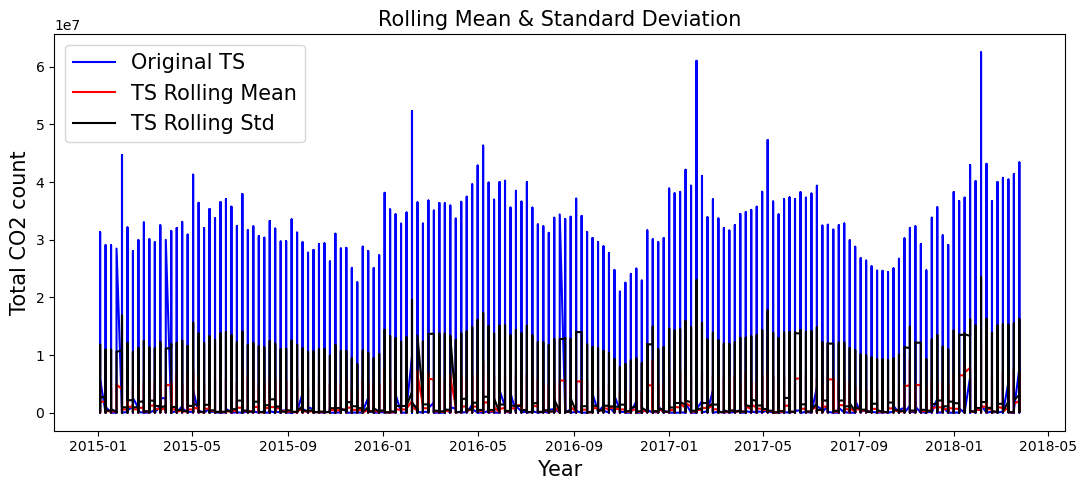

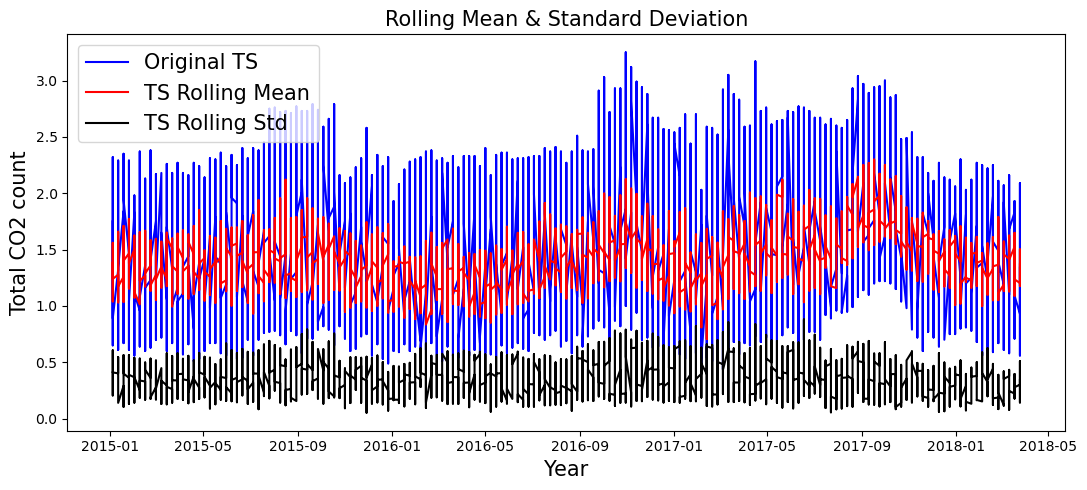

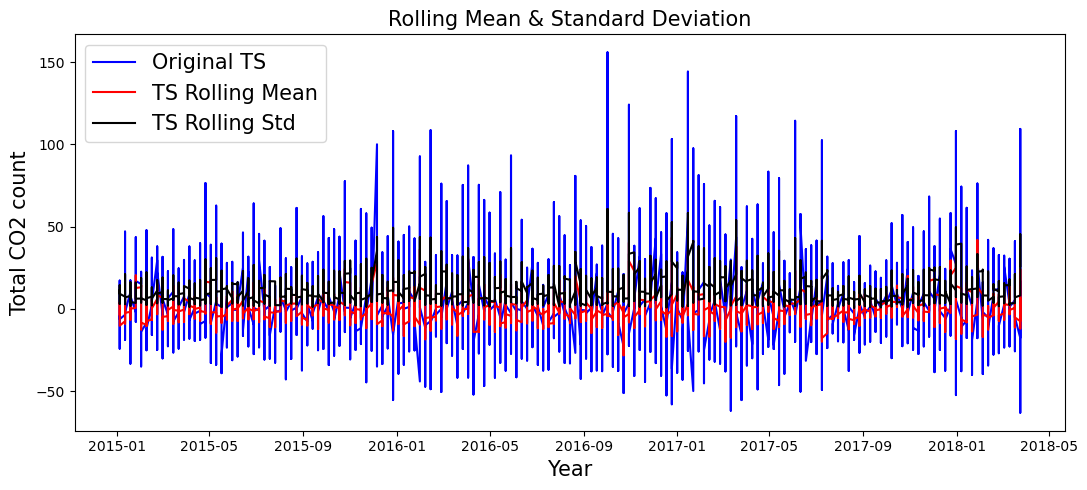

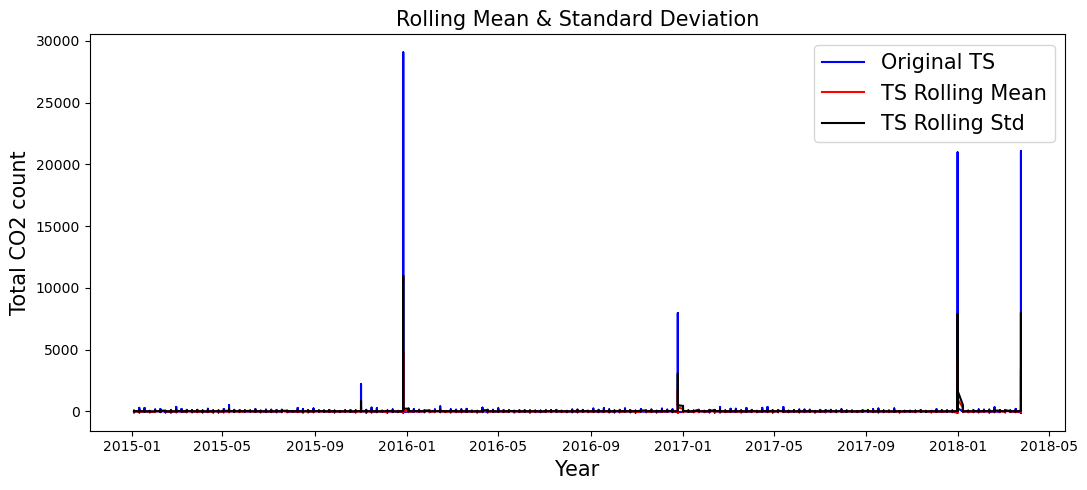

In [34]:
TestStationaryPlot(df.Total_sold) # data Total sold 
TestStationaryPlot(df.AveragePrice) # data AvgPrice
TestStationaryPlot(df.ret_price) # data return price
TestStationaryPlot(df.ret_sold) # data return sold

## Check Stationary

In [35]:
#define a function to perform the Dicky Fuller test on the time series
def DFTestStationary(ts):
    """
    This function used for 
    test stationary with addfuller
    """
    print('Dicky Fuller test:')
    df_test = adfuller(ts.iloc[:,0].values, autolag = 'AIC')
    df_test[4].items()
    df_output = pd.Series(df_test[0:4], index=['Test statistic', 'p-value', 'Lags used', 'No of observations used']) #show test statistic value
    for key, value in df_test[4].items():
        df_output['Critical value (%s)' %key] = value
    print(df_output) #show critical values and p value

In [36]:
DFTestStationary(df_sold) # check stationary data sold
DFTestStationary(df_price) # check stationary data avgprice
DFTestStationary(df_ret_price) # check stationary data return price
DFTestStationary(df_ret_sold) # check stationary data return sold

Dicky Fuller test:
Test statistic              -134.848701
p-value                        0.000000
Lags used                      0.000000
No of observations used    18248.000000
Critical value (1%)           -3.430708
Critical value (5%)           -2.861698
Critical value (10%)          -2.566854
dtype: float64
Dicky Fuller test:
Test statistic            -7.828961e+00
p-value                    6.368709e-12
Lags used                  4.200000e+01
No of observations used    1.820600e+04
Critical value (1%)       -3.430709e+00
Critical value (5%)       -2.861699e+00
Critical value (10%)      -2.566855e+00
dtype: float64
Dicky Fuller test:
Test statistic            -1.316693e+01
p-value                    1.273370e-24
Lags used                  3.300000e+01
No of observations used    1.821500e+04
Critical value (1%)       -3.430709e+00
Critical value (5%)       -2.861699e+00
Critical value (10%)      -2.566854e+00
dtype: float64
Dicky Fuller test:
Test statistic            -1.120879e+01

Result: 
- we get that which have high significant (p-value < 0.05) is column Total_sold the mean is stationary
- we can see except column Total_sold that it is not stationary as the p-value is >0.05 and the test statistic is greater than the critical values.

*Lets examine the orginal time series to show it's trend and seasonal components. just main column >> avg_price

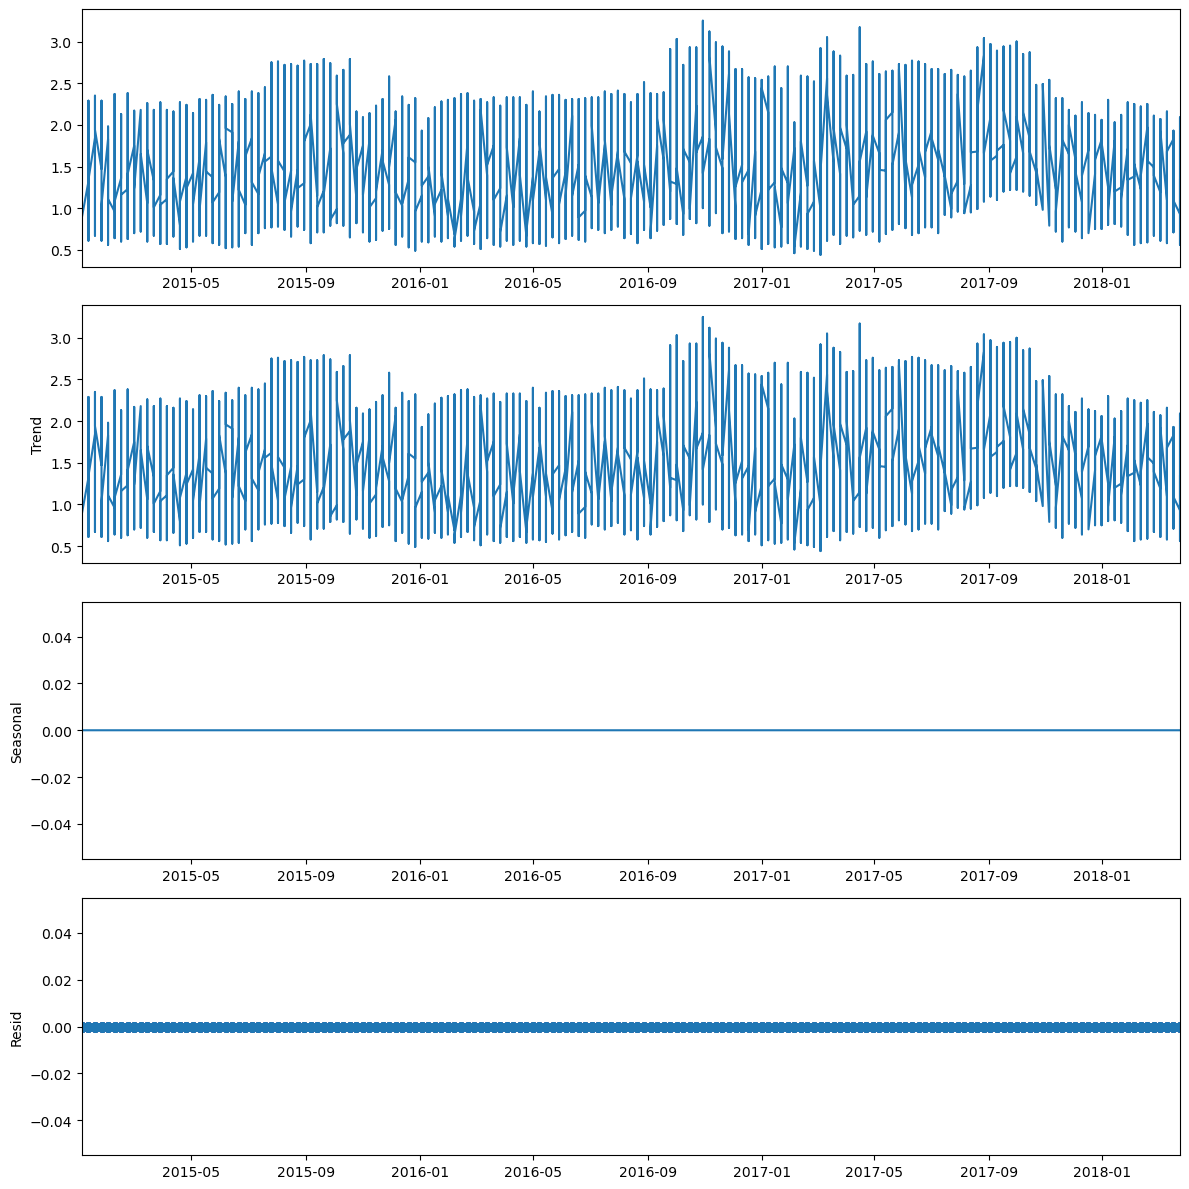

In [37]:
decompose = seasonal_decompose(df_price, model='addactive', period = 1) #Use seasonal decompose function to break down TS
plt.rcParams["figure.figsize"] = [12,12]
decompose.plot()
plt.show()

From result decompose we know that, trend this column is stabil nothing increasing or decrasing, but this is not stationary.If the data is not stationary, it is necessary to find the integrated parameter that makes the time-series into stationary.

## Autocorrelation (AR)

C:\Users\HP Notebook\AppData\Local\Temp\ipykernel_23044\3423491283.py:3: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  plot_acf(df_price, unbiased=True, zero=False, lags=40, ax=ax)


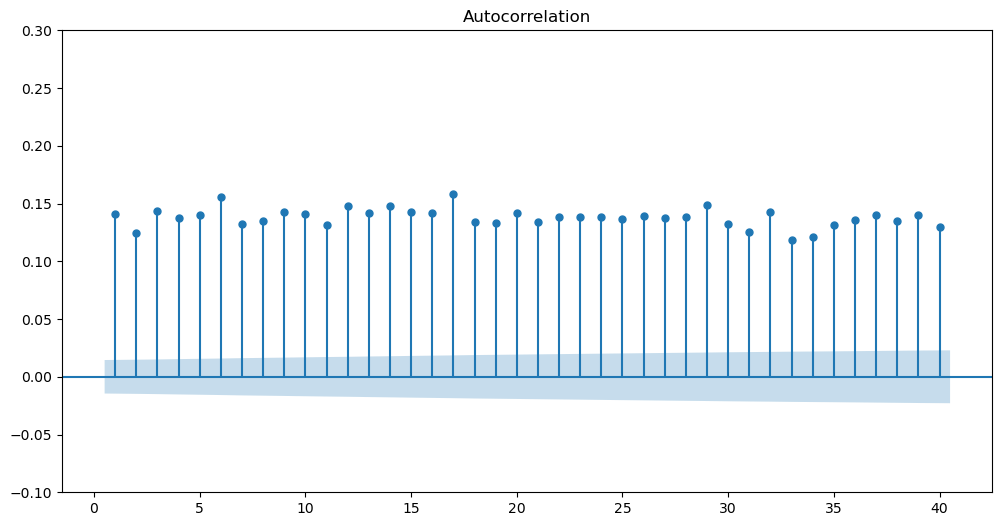

In [38]:
# check auto correlation acf
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df_price, unbiased=True, zero=False, lags=40, ax=ax)
plt.ylim(-0.1, 0.3)
plt.show()

from result acf we know that blue area is 95% confident interval, but the result nothing in blue areas. The mean is not null, non-null values in AR indicate a pattern of dependency on the data and can be used to predict future values (all lags).>> Not Stationar

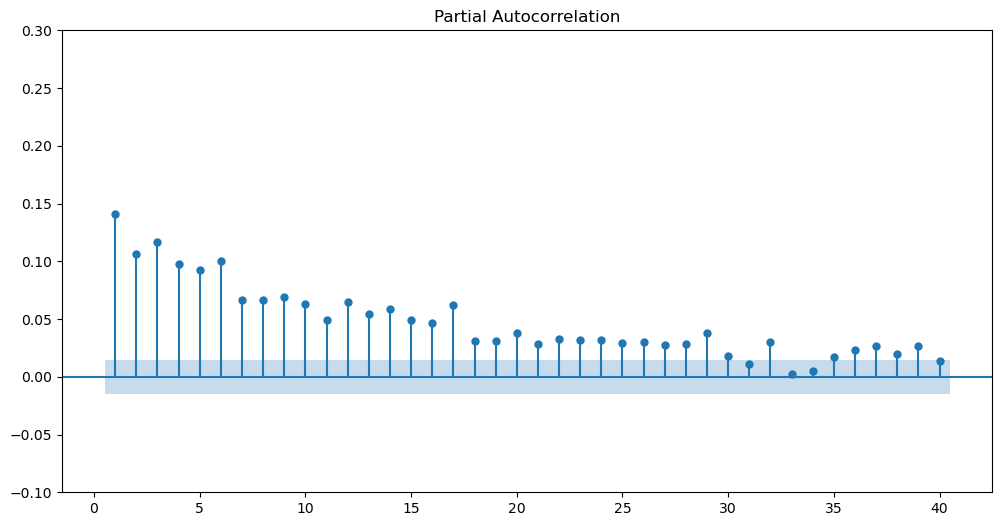

In [39]:
# check auto correlation pacf
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(df_price, lags=40, alpha=0.05, zero=False, method='ols', ax=ax)
plt.ylim(-0.1, 0.3)
plt.show()

Result from pacf that lag-1 there is a drastic change every 5 lags, this event occurs up to lag-17. There is a lag that is included in the blue area which means it is still in the null value, which means there is no dependence on the previous values ​​in the time series (lags 31, 33,34 and 39). >> Not Stationar

# Make to stationary with differencing

As mentioned previously, we can subtract a set of values from the TS to try and achieve stationarity. Another way of doing this is differencing. Differencing is the method of subtracting a value n positions before the current data point. This method helps eliminate seasonality and trends from the TS.

There are different types of differencing that we will use. These are; a) First differencing b) Seasonal differencing c) Seasonal first differencing

### a. First Difference

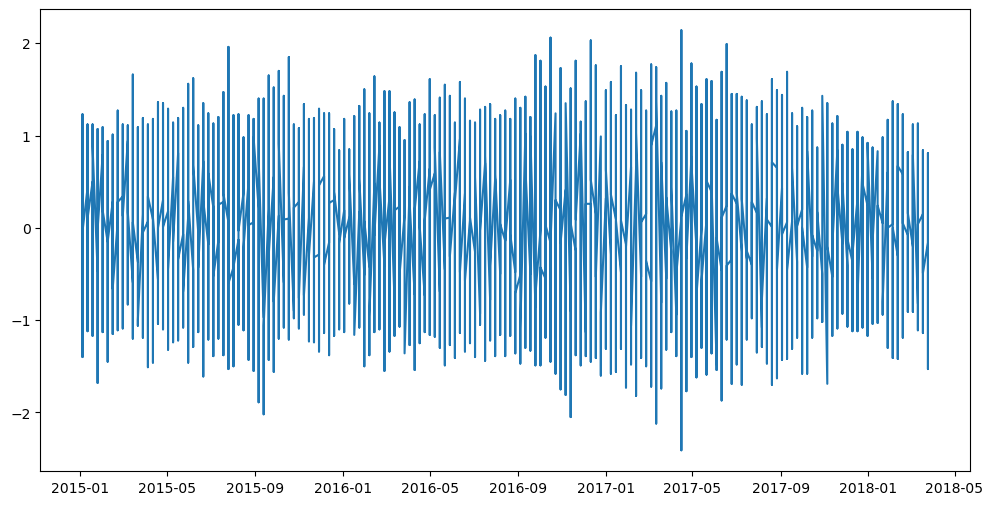

In [40]:
dataset_shifted_price = df_price - df_price.shift(1) #1st difference
dataset_shifted_price.dropna(inplace = True)

# plot
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(dataset_shifted_price)

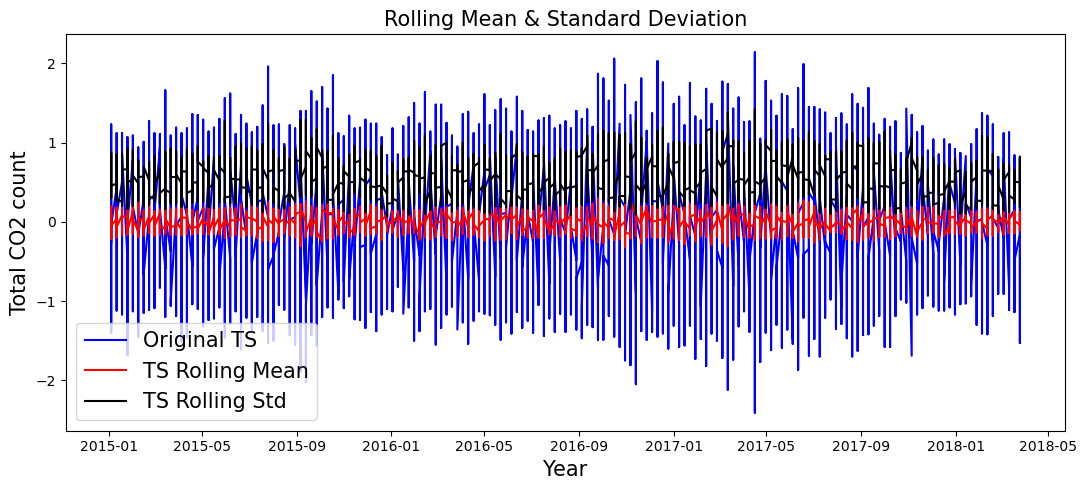

In [41]:
TestStationaryPlot(dataset_shifted_price)

In [42]:
DFTestStationary(dataset_shifted_price)

Dicky Fuller test:
Test statistic               -31.406204
p-value                        0.000000
Lags used                     45.000000
No of observations used    18202.000000
Critical value (1%)           -3.430709
Critical value (5%)           -2.861699
Critical value (10%)          -2.566855
dtype: float64


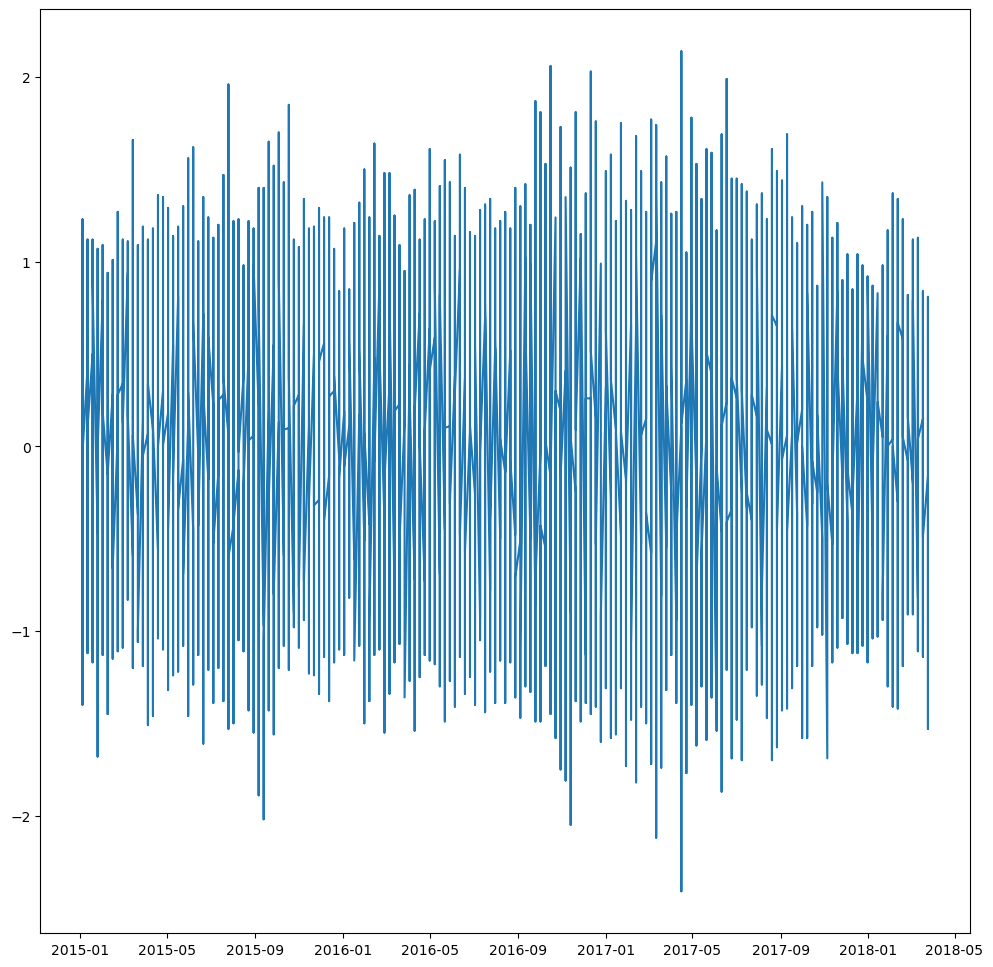

In [43]:
# plot result of transform
plt.plot(dataset_shifted_price)

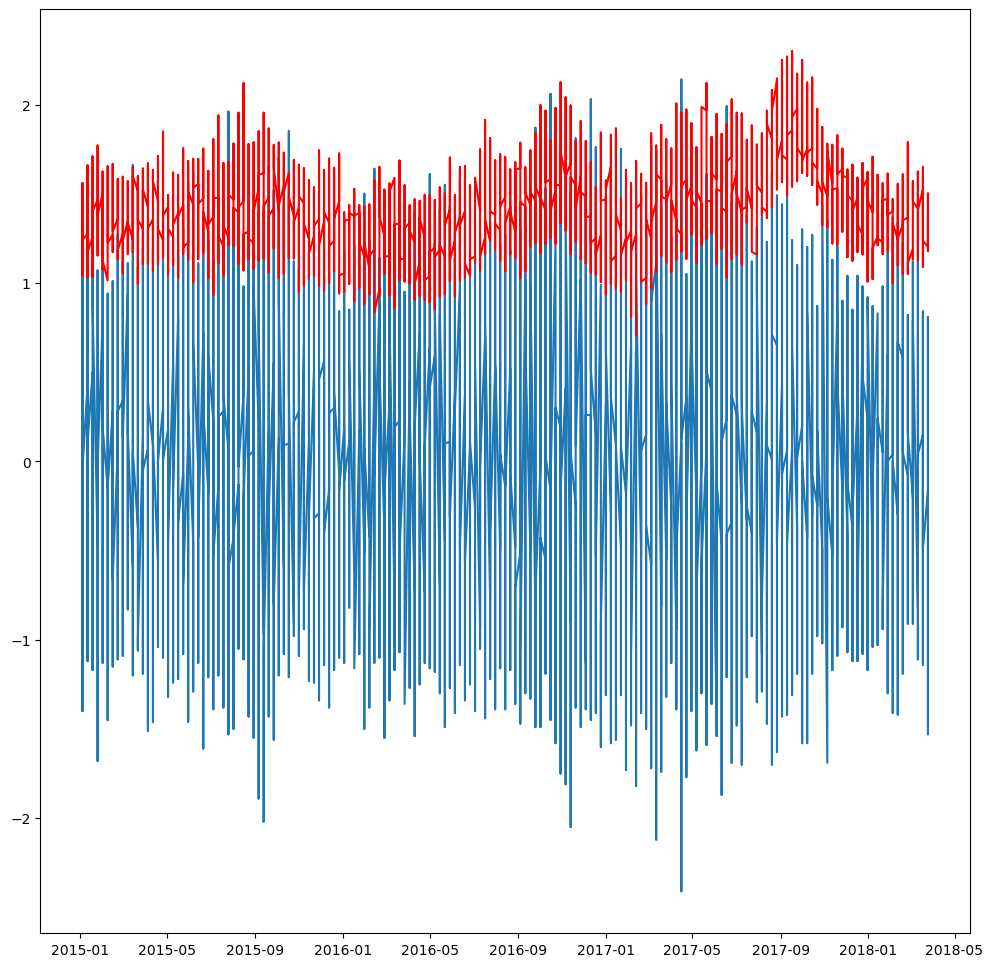

In [44]:
rolling_mean = df_price.rolling(window = 7, center = False).mean()
plt.plot(dataset_shifted_price)
plt.plot(rolling_mean, color='red')

the result is, when we use differensi 1 can be p-value < 0.05 and this is stationary. Now we will check AR (Autocorrelation)

C:\Users\HP Notebook\AppData\Local\Temp\ipykernel_23044\3988683965.py:3: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  plot_acf(dataset_shifted_price, unbiased=True, zero=False, lags=40, ax=ax)


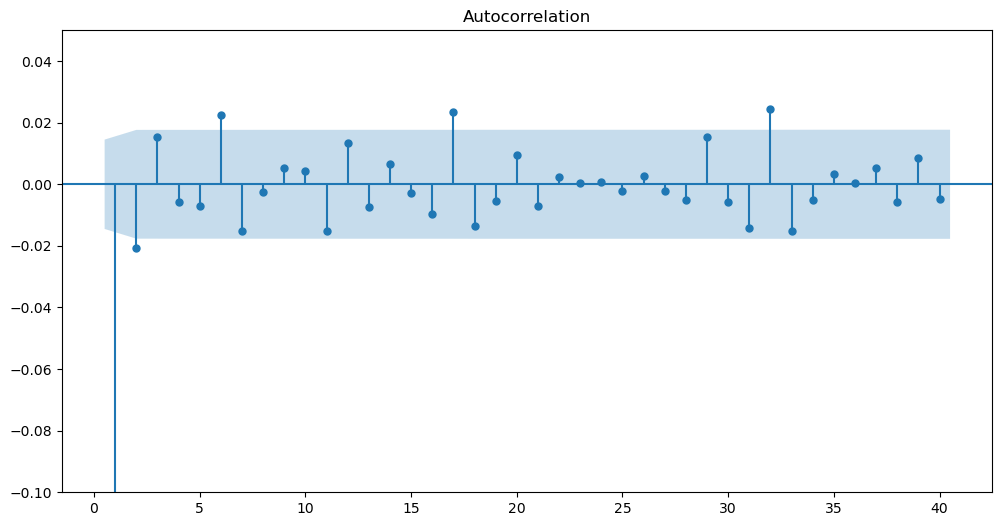

In [45]:
# check auto correlation acf
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(dataset_shifted_price, unbiased=True, zero=False, lags=40, ax=ax)
plt.ylim(-0.10, 0.05)
plt.show()

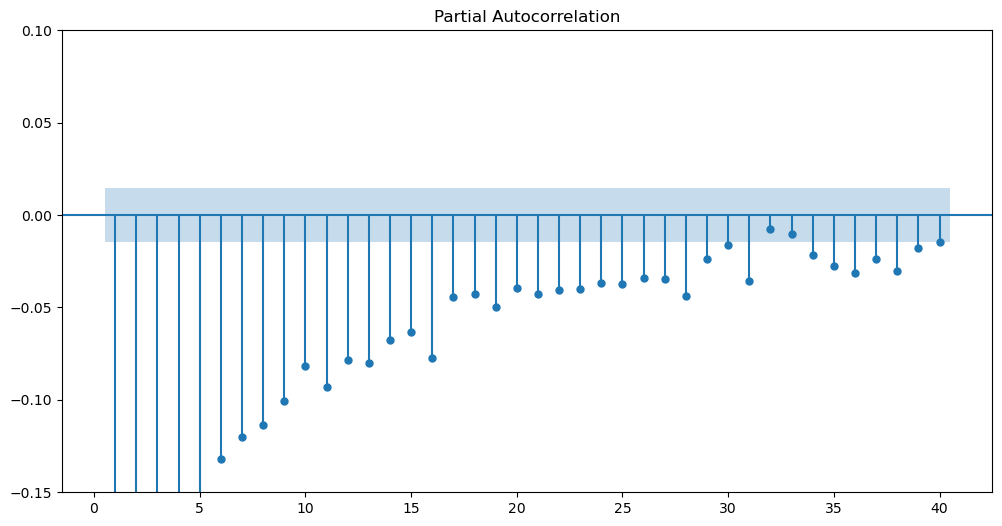

In [46]:
# check auto correlation pacf
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(dataset_shifted_price, lags=40, alpha=0.05, zero=False, method='ols', ax=ax)
plt.ylim(-0.15, 0.1)
plt.show()

after transformation data we get stationar AR(autoregretion) because mayority in blue area

# b. Seasonal difference

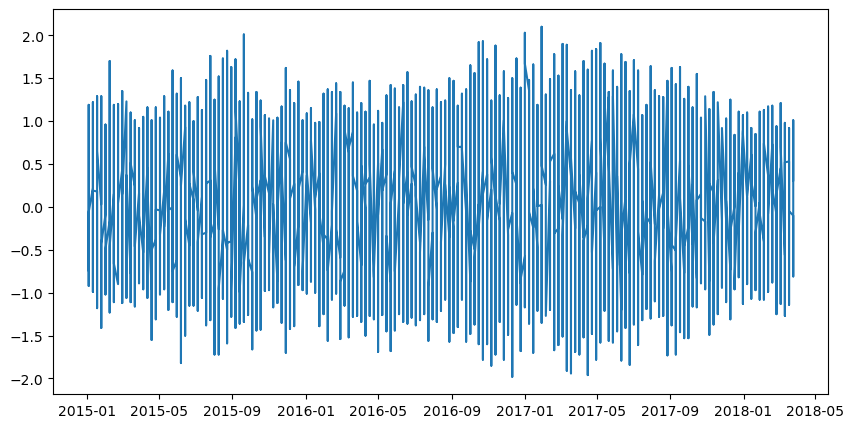

In [48]:
dataset_shifted_season = df_price - df_price.shift(12) #Seasonal difference
dataset_shifted_season.dropna(inplace = True)

plt.figure(figsize = (10,5))
plt.plot(dataset_shifted_season)

Dicky Fuller test:
Test statistic               -27.938312
p-value                        0.000000
Lags used                     44.000000
No of observations used    18192.000000
Critical value (1%)           -3.430710
Critical value (5%)           -2.861699
Critical value (10%)          -2.566855
dtype: float64


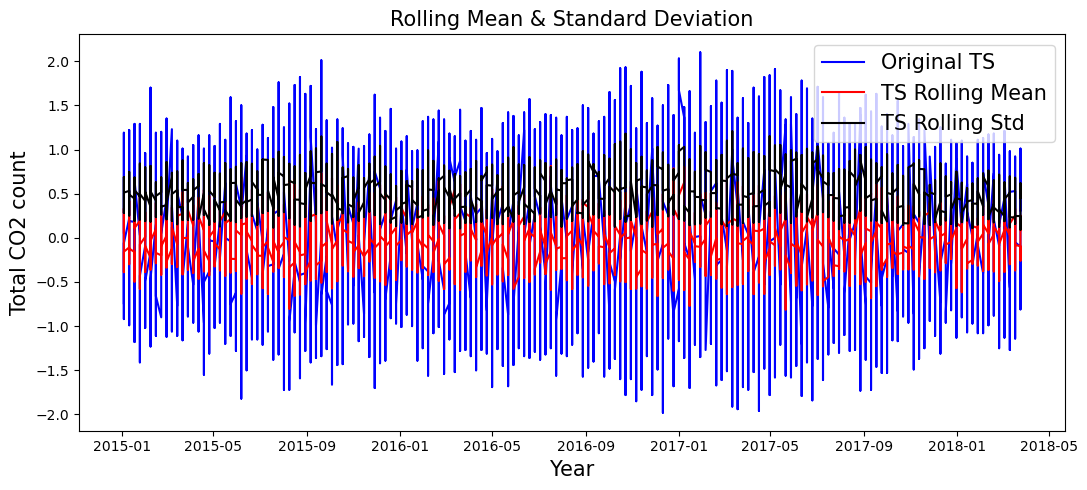

In [49]:
TestStationaryPlot(dataset_shifted_season)
DFTestStationary(dataset_shifted_season)

In [53]:
# save data
joblib.dump(dataset_shifted_price, "D:/BOOTCAMP/project/Project Pribadi/Udemy - Time Series Analysis in Python/data/data feature/df_price.csv")
joblib.dump(df, "D:/BOOTCAMP/project/Project Pribadi/Udemy - Time Series Analysis in Python/data/data feature/df_time.csv")
joblib.dump(dataset_shifted_season, "D:/BOOTCAMP/project/Project Pribadi/Udemy - Time Series Analysis in Python/data/data feature/df_season.csv")

['D:/BOOTCAMP/project/Project Pribadi/Udemy - Time Series Analysis in Python/data/data feature/df_season.csv']